##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Gemma models in Keras using LoRA


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lora_tuning"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of billions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685){:.external} is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k){:.external}. This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on [kaggle.com](https://kaggle.com){:.external}.
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select &#9662; (**Additional connection options**).
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Configure your API key

To use Gemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.

In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.


### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [1]:
import os
#from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = "eunhuikim"#userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = "2e5677c209d079712edc76340acdb21d" #userdata.get('KAGGLE_KEY')

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [2]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 879.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


### Select a backend

Keras is a high-level, multi-framework deep learning API designed for simplicity and ease of use. Using Keras 3, you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

For this tutorial, configure the backend for JAX.

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

In [3]:
os.environ["KERAS_BACKEND"] = "torch"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [4]:
import keras
import keras_nlp

## Load Dataset

In [6]:
!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

--2024-05-13 08:27:58--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.24, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1715848078&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTg0ODA3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRhY

Preprocess the data. This tutorial uses a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [7]:
import json
data = []
with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

datagrick data 추가 분석
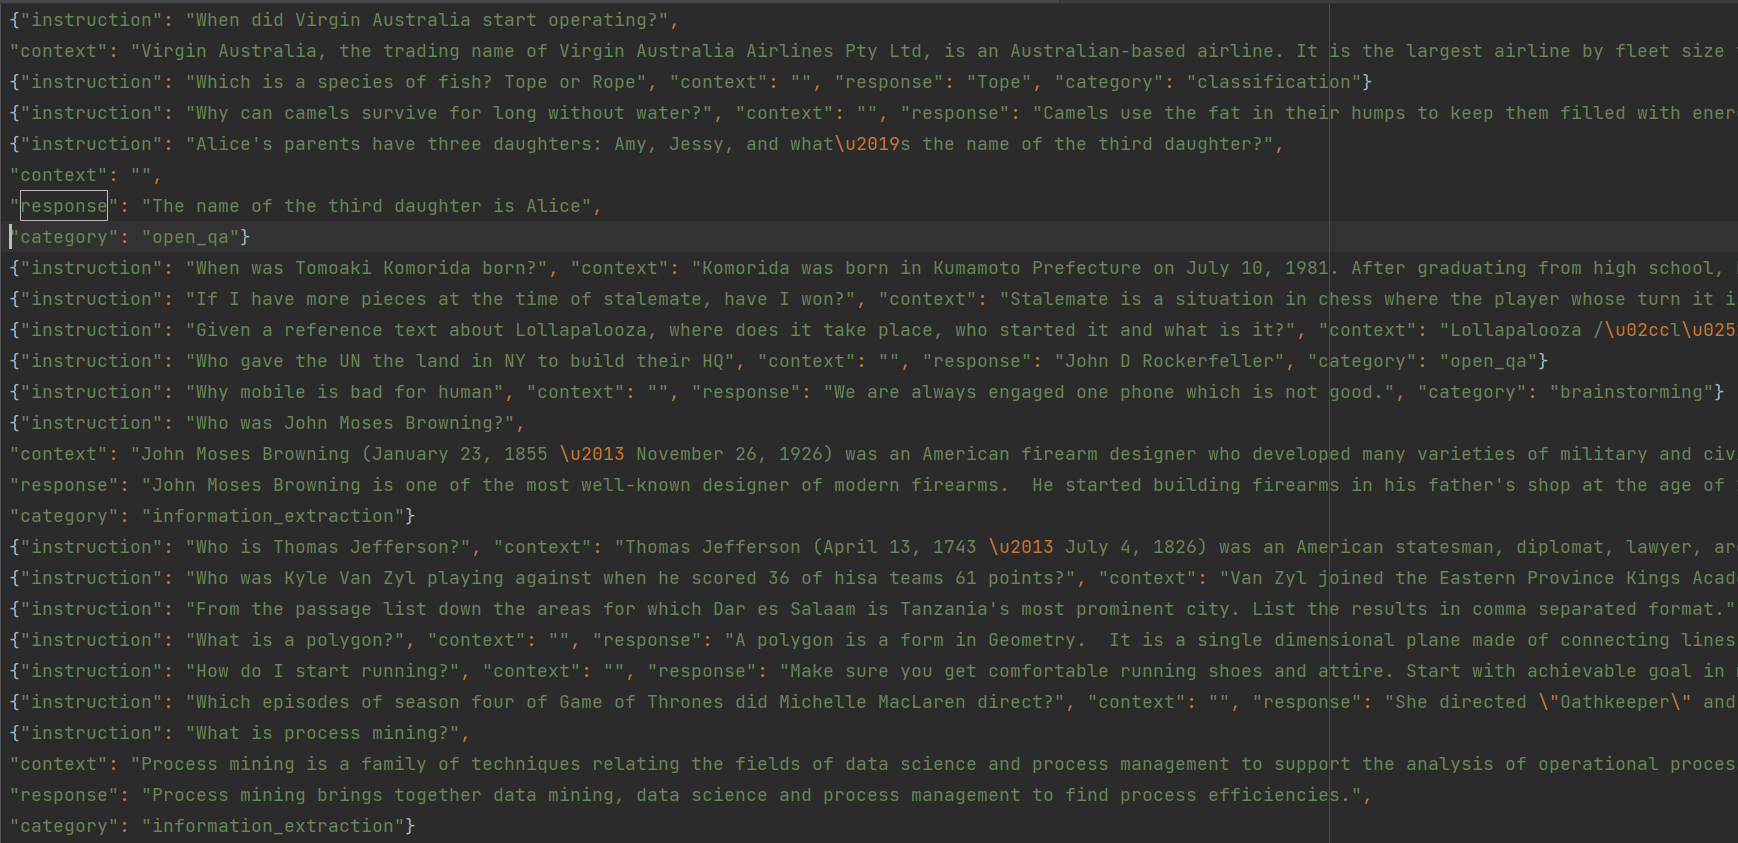

In [8]:
import json

categories = set()

with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        if 'category' in features:
            categories.add(features['category'])

unique_categories = list(categories)

print(unique_categories)
print(len(unique_categories))

['general_qa', 'creative_writing', 'information_extraction', 'summarization', 'closed_qa', 'open_qa', 'brainstorming', 'classification']
8


## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/){:.external}. In this tutorial, you'll create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [9]:
import torch

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    # 가용한 GPU 디바이스 설정 (예: 첫 번째 GPU 사용)
    device = torch.device("cuda:0")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# 모델을 GPU로 이동 (GPU 사용이 가능한 경우)
gemma_lm = gemma_lm.to(device)

gemma_lm.summary()

Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'task.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Colab notebook...
Attaching 'metadata.json' from model 

GPU is available. Using GPU: Tesla T4


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import importlib.util
print(importlib.util.find_spec("safetensors") is not None)

True


In [10]:
!pip install accelerate==0.24.1
!pip install huggingface-hub==0.19.3
!pip install safetensors==0.4.1
!pip install tokenizers==0.14.1
!pip install transformers==4.38.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.3
    Uninstalling safetensors-0.4.3:
      Successfully uninstalled safetensors-0.4.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.19.3
    Uninstalling huggingface-hub-0.19.3:
      Successfully uninstalled huggingface-hub-0.19.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.40.2 requires huggingface-hub<1.0,>=

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 41.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

## Inference before fine tuning

In this section, you will query the model with various prompts to see how it responds.


### Europe Trip Prompt

Query the model for suggestions on what to do on a trip to Europe.

In [10]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
1. Take a trip to Europe.
2. Take a trip to Europe.
3. Take a trip to Europe.
4. Take a trip to Europe.
5. Take a trip to Europe.
6. Take a trip to Europe.
7. Take a trip to Europe.
8. Take a trip to Europe.
9. Take a trip to Europe.
10. Take a trip to Europe.
11. Take a trip to Europe.
12. Take a trip to Europe.
13. Take a trip to Europe.
14. Take a trip to Europe.
15. Take a trip to Europe.
16. Take a trip to Europe.
17. Take a trip to Europe.
18. Take a trip to Europe.
19. Take a trip to Europe.
20. Take a trip to Europe.
21. Take a trip to Europe.
22. Take a trip to Europe.
23. Take a trip to Europe.
24. Take a trip to Europe.
25. Take a trip to


The model just responds with a recommendation to take a trip to Europe.

### ELI5 Photosynthesis Prompt

Prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Photosynthesis is the process by which plants use the energy from the sun to convert water and carbon dioxide into oxygen and glucose. The process begins with the absorption of light energy by chlorophyll molecules in the leaves of plants. The energy from the light is used to split water molecules into hydrogen and oxygen. The oxygen is released into the atmosphere, while the hydrogen is used to make glucose. The glucose is then used by the plant to make energy and grow.

Explanation:
Photosynthesis is the process by which plants use the energy from the sun to convert water and carbon dioxide into oxygen and glucose. The process begins with the absorption of light energy by chlorophyll molecules in the leaves of plants. The energy from the light is used to split water molecules into hydrogen and oxygen. The oxygen is released into the atmosphere, while the hydrogen is used to make gluc

The responses contains words that might not be easy to understand for a child such as chlorophyll, glucose, etc.

## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

In [ ]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1409s 1s/step - loss: 0.4589 - sparse_categorical_accuracy: 0.5235


## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

### Europe Trip Prompt


In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
You should visit all the major European capitals and cities such as London, Paris, Rome, and Barcelona. You can also go to the countryside and visit the countryside, which is a very beautiful part of the world.


The model now recommends places to visit in Europe.

### ELI5 Photosynthesis Prompt


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Photosynthesis is a process that uses energy from the sun to produce glucose from water and carbon dioxide.


The model now explains photosynthesis in simpler terms.

Note that for demonstration purposes, this tutorial fine-tunes the model on a small subset of the dataset for just one epoch and with a low LoRA rank value. To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank
4. Modifying the hyperparameter values such as `learning_rate` and `weight_decay`.


## Summary and next steps

This tutorial covered LoRA fine-tuning on a Gemma model using KerasNLP. Check out the following docs next:

* Learn how to [generate text with a Gemma model](https://ai.google.dev/gemma/docs/get_started).
* Learn how to perform [distributed fine-tuning and inference on a Gemma model](https://ai.google.dev/gemma/docs/distributed_tuning).
* Learn how to [use Gemma open models with Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma){:.external}.
* Learn how to [fine-tune Gemma using KerasNLP and deploy to Vertex AI](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_gemma_kerasnlp_to_vertexai.ipynb){:.external}.
